# Water balance assessment for water resource planning in a data-limited region case study  in the Lunsemfwa Basin 
# Introduction
This script outlines an assessment of water availability in the Lunsemfwa Basin, with a focus on identifying hotspots of water availability. In cases where data is limited and for long-term assessments, the Water balance method would provide insights by assuming a steady state system (change in storage = 0). Thus, only rainfall and actual evapotranspiration data were used for this exercise.

The Lunsemfwa River Basin, located in central Zambia, is a key sub-basin of the Lower Luangwa catchment. It originates from the Mkushi and Kapiri Mposhi districts and drains through parts of Kabwe and Luano before joining the Lukanga Swamps. The basin supports diverse land uses, including rainfed and irrigated agriculture, hydropower generation (Lunsemfwa and Mulungushi dams), livestock rearing, and rural settlements. 

Conducting a water balance assessment (Rainfall − ETa) is crucial for understanding the basin’s hydrological dynamics and managing its water resources sustainably. By comparing rainfall inputs with actual evapotranspiration losses, the assessment quantifies available water for runoff, recharge, and ecosystem services. It helps identify areas of water surplus or deficit, supports irrigation planning, reservoir operations, and drought early warning, and strengthens decision-making for climate-resilient water allocation. 


**Approach**  
The analysis was conducted for the period 2003 to 2021, the time period for which ETa  data is available. For the water balance that covers more than 10 years, one can ignore storage when the data is limited. 
The runoff were reclassified into five classes to identify hotspots of dry and wet conditions.  
Five classes were generated, namely:  
* Very wet
* Moderately wet
* normal
* Moderately dry
* Very dry  



# Packages  
Install and import packages and functions

In [1]:
#  To learn what each line of code does, please read the description of each line written in a comment.
%matplotlib inline
import os
os.environ["USE_PYGEOS"] = "0"
import sys  # for accessing and modifying Python path
import datacube                 # For loading data from DE Africa
import numpy as np              # Package for handling multidimensional (ndarray) arrays
import pandas as pd             # For handling tabular data, spreadsheet-like
import geopandas  as gpd        # For vector data handling
import xarray as xr             # For handling labeled ndarrays
import rioxarray as rxr         # Provide geospatial data handling capabilities to xarray
import matplotlib.pyplot as plt # Package for plotting
from datacube.utils import geometry
from rasterio.enums import Resampling
import fsspec                   # fsspec: Provides a unified interface for accessing files from various locations, like S3.

# For defining a custom color ramp and legend
import matplotlib.colors as mcolors
import matplotlib.patches as mpatches
import cmocean

In [2]:
# Provides a dashboard for multi-process computation and diagnostics
from deafrica_tools.plotting import (map_shapefile, rgb, xr_animation)
from deafrica_tools.spatial import xr_rasterize
# For computing zonal statistics
from rasterstats import zonal_stats
# Help manipulate calendar
import calendar
# To silence version warnings
import warnings
warnings.filterwarnings("ignore")
# plotting style which simulates r-ggplot
plt.style.use('ggplot')
# Packages for ETa data loading
!pip install h5netcdf h5py netcdf4 --quiet
import h5netcdf
#import netcdf4
import s3fs


[notice] A new release of pip is available: 25.0 -> 25.3
[notice] To update, run: pip install --upgrade pip


# Data import
## Connect to datacube
To gain access to the datasets stored in the DE Africa data repository, we must establish a connection with the datacube.
It is recommended that the  *app*  parameter uses a user-defined argument that must be distinct and correspond to the name of the notebook. For example, in this exercise, the name of the notebook is `Lunsenfwa_water_availability`, so the *app* parameter when calling the Datacube is also named as `Lunsenfwa_water_availability`. See code below. You can change this name as you want but ensure consistency.

In [3]:
dc = datacube.Datacube(app='Lunsenfwa_water_availability')

## Load study area shapefiles  
The next step is to load the shapefiles of the study area where we are working. Keep track of the projection of your study area catchment because it is very vital in this exercise. Follow the steps below to load your shapefiles into the notebook.

In [4]:
# Step 1:
# Set the path to the shapefile for the area of interest and give it a name
aoi = "Data/lusen_outline.json"

output_dir = "Results"

# Step 2:
# Read/load the shapefile into the notebook using the geopandas package
lusen_bnd = gpd.read_file(aoi)
lusen_bnd = lusen_bnd.to_crs(epsg=4326) # set crs to WGS84

# Necessary for datacube access
geom = geometry.Geometry(lusen_bnd.unary_union, lusen_bnd.crs)

# View the attribute table of the shapefile
lusen_bnd.head()

,FID,OBJECTID,Shape_Leng,Shape_Area,geometry
0,0,1,884601.162289,2.222525e+10,"POLYGON ((29.60595 -13.22632, 29.60651 -13.227..."


**Plot the study area**  
Next step is to visualize the study area by plotting the shapefile boundary interactively using the .explore() from geopandas package. .
Type the code below and run it.

In [5]:
lusen_bnd.explore()

## Load Rainfall

### Creating data loading parameters  
The first step in loading a dataset in DEA sandbox is to define some parameters that the function will use to get the dataset. See below for the set of parameters defined for rainfall. We are using CHIRPS data for this exercise.    

In [6]:
# Define the period of interest
year_range = ("2003", "2021")

# CHIRPS has a spatial resolution ~ 5x5 km (0.05) but we can select what works best for us
resolution = (-0.0025, 0.0025)

# size of the dask chunks
dask_chunks =  dict(longitude=500, latitude=500)

query = {
    'geopolygon':geom,
    'time': year_range,
    'output_crs': 'epsg:4326', # WGS 1984 geographic oordinates
    'resolution': resolution,
    'measurements': ['rainfall'], # from list of measurements
    'dask_chunks':dask_chunks
}

### Load and view rainfall data  
We are using the dc.load function to retrieve CHIRPS rainfall data for the specified query parameters from DEA and then display the resulting xarray.Dataset, allowing you to inspect the loaded rainfall time series for the area and period of interest.

In [7]:
# Load the data
ds_rainfall = dc.load(product='rainfall_chirps_monthly', **query)

# Prints the resolution of the rainfall dataset 
print("Resolution:", ds_rainfall.rio.resolution())

# View the dataset
ds_rainfall

Resolution: (0.002499999999999999, -0.0025000000000000005)


<xarray.Dataset> Size: 481MB
Dimensions:      (time: 228, latitude: 747, longitude: 706)
Coordinates:
  * time         (time) datetime64[ns] 2kB 2003-01-16T11:59:59.500000 ... 202...
  * latitude     (latitude) float64 6kB -13.2 -13.2 -13.21 ... -15.06 -15.07
  * longitude    (longitude) float64 6kB 28.04 28.04 28.04 ... 29.79 29.8 29.8
    spatial_ref  int32 4B 4326
Data variables:
    rainfall     (time, latitude, longitude) float32 481MB dask.array<chunksize=(1, 500, 500), meta=np.ndarray>
Attributes:
    crs:           EPSG:4326
    grid_mapping:  spatial_ref

### Mask to geographic area of interest  
Here we clip the rainfall dataset to the basin boundary defined by the shapefile, ensuring that only data within the area of interest is retained.

In [8]:
# Clip to basin boundary
rainfall = ds_rainfall.rio.clip(lusen_bnd.geometry) # clip and and rename variable as "rainfall"

# Rasterize and remove the areas outside the aoi
mask = xr_rasterize(lusen_bnd, rainfall) # lusen_bnd is the geopanda data frame obtained from the shapefile
rainfall = rainfall.where(rainfall>=0) # this ensures that the area outside the polygon is removed.

## Load Evapotranspiration  
Loading ETa data is a bit different form the rainfall. The ETa data is sitting on a cloud storage outside of the datacube. This we must read it from cloud storage, download and load into the notebook. Follow the following code to get the ETa data.

In [9]:
# Open the NetCDF file using s3fs and xarray
# URL to the NetCDF file
afr_eta_url = "s3://iwmiwapublic/Continental/Africa/Netcdfs/AFR_ETa_SSEBop_yearly.nc"

fs = fsspec.filesystem('s3', anon=True) # fs: Creates an S3 filesystem object using fsspec.
# size of the dask chunks
dask_chunks =  dict(longitude=500, latitude=500)

# downloading data and extracting
with fs.open(afr_eta_url) as f:
    AFR_ETa = xr.open_dataset(f, engine="h5netcdf", chunks = dask_chunks)
    AFR_ETa = AFR_ETa.rio.write_crs(lusen_bnd.crs).sel(time=slice("2003", "2021"))
    AFR_ETa = AFR_ETa.rio.clip(lusen_bnd.geometry, lusen_bnd.crs)
    AFR_ETa = AFR_ETa.where(AFR_ETa>=0)
    AFR_ETa.attrs["units"] = "mm/month"
    AFR_ETa = AFR_ETa.compute()
# display the results
print(AFR_ETa)

# Check the resolution of the ETa
print("ETa resolution:", AFR_ETa.rio.resolution())

<xarray.Dataset> Size: 33MB
Dimensions:      (time: 228, latitude: 195, longitude: 185)
Coordinates:
  * time         (time) datetime64[ns] 2kB 2003-01-01 2003-02-01 ... 2021-12-01
  * latitude     (latitude) float32 780B -13.21 -13.22 -13.23 ... -15.05 -15.06
  * longitude    (longitude) float32 740B 28.04 28.05 28.06 ... 29.78 29.79
    spatial_ref  int64 8B 0
Data variables:
    ETa          (time, latitude, longitude) float32 33MB nan nan ... nan nan
Attributes:
    basin_name:  AFR
    units:       mm/month
ETa resolution: (0.009521930114082668, -0.009521931717076252)


# Analysis  
## Water balance for entire catchment
The first thing is to make sure that both datasets are in the same time period, projection and resolution. To do that, we first check the **`CRS`** of the two dataset if they exist. 

In [10]:
# Checking for crs
print(AFR_ETa.spatial_ref.attrs), print(rainfall.spatial_ref.attrs)

{'crs_wkt': 'GEOGCS["WGS 84",DATUM["WGS_1984",SPHEROID["WGS 84",6378137,298.257223563]],PRIMEM["Greenwich",0],UNIT["degree",0.0174532925199433,AUTHORITY["EPSG","9122"]],AXIS["Latitude",NORTH],AXIS["Longitude",EAST],AUTHORITY["EPSG","4326"]]', 'semi_major_axis': 6378137.0, 'semi_minor_axis': 6356752.314245179, 'inverse_flattening': 298.257223563, 'reference_ellipsoid_name': 'WGS 84', 'longitude_of_prime_meridian': 0.0, 'prime_meridian_name': 'Greenwich', 'geographic_crs_name': 'WGS 84', 'horizontal_datum_name': 'World Geodetic System 1984', 'grid_mapping_name': 'latitude_longitude', 'spatial_ref': 'GEOGCS["WGS 84",DATUM["WGS_1984",SPHEROID["WGS 84",6378137,298.257223563]],PRIMEM["Greenwich",0],UNIT["degree",0.0174532925199433,AUTHORITY["EPSG","9122"]],AXIS["Latitude",NORTH],AXIS["Longitude",EAST],AUTHORITY["EPSG","4326"]]', 'GeoTransform': '28.035045400909755 0.009521930114082668 0.0 -13.20586658998863 0.0 -0.009521931717076252'}
{'crs_wkt': 'GEOGCS["WGS 84",DATUM["WGS_1984",SPHEROID["W

(None, None)

The results show rainfall has no crs attached. This means that we will need to assign one to it before we can proceed. But from the original dataset, we know that the **`crs`** for the **`CHIRPS`** rainfall is in the **`WGS 84 (EPSG:4326)`** which is same for ETa. So thats what we will assign to it.

In [11]:
# Assign the CRS and check if its successful.
rainfall_crs = rainfall.rainfall.rio.write_crs("EPSG:4326", inplace=True)
rainfall_crs.spatial_ref.attrs

{'crs_wkt': 'GEOGCS["WGS 84",DATUM["WGS_1984",SPHEROID["WGS 84",6378137,298.257223563,AUTHORITY["EPSG","7030"]],AUTHORITY["EPSG","6326"]],PRIMEM["Greenwich",0,AUTHORITY["EPSG","8901"]],UNIT["degree",0.0174532925199433,AUTHORITY["EPSG","9122"]],AXIS["Latitude",NORTH],AXIS["Longitude",EAST],AUTHORITY["EPSG","4326"]]',
 'semi_major_axis': 6378137.0,
 'semi_minor_axis': 6356752.314245179,
 'inverse_flattening': 298.257223563,
 'reference_ellipsoid_name': 'WGS 84',
 'longitude_of_prime_meridian': 0.0,
 'prime_meridian_name': 'Greenwich',
 'geographic_crs_name': 'WGS 84',
 'horizontal_datum_name': 'World Geodetic System 1984',
 'grid_mapping_name': 'latitude_longitude',
 'spatial_ref': 'GEOGCS["WGS 84",DATUM["WGS_1984",SPHEROID["WGS 84",6378137,298.257223563,AUTHORITY["EPSG","7030"]],AUTHORITY["EPSG","6326"]],PRIMEM["Greenwich",0,AUTHORITY["EPSG","8901"]],UNIT["degree",0.0174532925199433,AUTHORITY["EPSG","9122"]],AXIS["Latitude",NORTH],AXIS["Longitude",EAST],AUTHORITY["EPSG","4326"]]',
 'Geo

Now that we have assigned the crs to the rainfall data, we will **`reproject`** it to the same projection and resolution as the ETa data so that we can perform the necessary operations. it is also important to note that the spatial dimensions for both dataset have different names so it has to be renamed to match for the operations to work. Next step will be to rename the `x` and `y` in the rainfall to `longitude` and `latitude` respectively.

In [12]:
# Reprojecting rainfall data to match the ETa data
reproj_rainfall = rainfall_crs.rio.reproject_match(AFR_ETa, resampling=Resampling.bilinear)

# Renaming x and y to longitude and latitude
reproj_rainfall = reproj_rainfall.rename({'y': 'latitude', 'x': 'longitude'})

You can now check the resolution of the reprojected rainfall data and the ETa.

In [13]:
print("ETa resolution:", AFR_ETa.rio.resolution()) # For ETa
print("Rainfall resolution:", reproj_rainfall.rio.resolution()) # For Rainfall

ETa resolution: (0.009521930114082668, -0.009521931717076252)
Rainfall resolution: (0.009521930114082668, -0.009521931717076252)


Now the ETa and the rainfall have the same resolution and spatial properties. Thus, the analysis can proceed.

### Grouping of Rainfall and ETa into a monthly time scale  
Both rainfall and ETa data are summarised at monthly time scales. The water balance will be conducted at both the monthly and annual scales. For now, we focus on the monthly scale. The reprojected rainfall data is first clipped to the study area, grouped by month, and cleaned of any null or invalid (negative) values. Similarly, ETa data is grouped to calculate monthly means. Finally, the monthly water balance is calculated by subtracting ETa from rainfall

In [14]:
# Rainfall
# Clipping the reprojected rainfall to the study area
reproj_rainfall_masked = reproj_rainfall.rio.clip(lusen_bnd.geometry, drop=True)

# Computing mean monthly rainfall  over the period
reproj_rainfall_mean_month = reproj_rainfall_masked.groupby('time.month').mean('time').compute()

# Calculation of the monthly mean introduces ‘nodata’ values of ‘-99999’ in areas outside the study area and must be removed for smooth computations and visualization. 
# The code below gets rid of these values and only values within the study area will remain. 
reproj_rainfall_mean_month = reproj_rainfall_mean_month.where(reproj_rainfall_mean_month>=0)  

# ETA
# First, extract the ETa variable  from the dataset and group the dataset into monthly timescale
ETa = AFR_ETa['ETa']    # retrieves ETa from the AFR_ETa dataset by indexing and stores it as ETa                               
ETa_monthly_mean = ETa.groupby('time.month').mean('time').compute() # computing monthly ETa averages

**Plot Monthly Water balance**  
Here we visualize the monthly water balance, calculated as rainfall minus Eta across the year. We first inspect the range of values in the dataset to set appropriate limits for the color scale. A customized colormap is applied for clear visual distinction of values, and the data is plotted.

In [15]:
# Water Balance at monthly scale
# Subtract ETa from Rainfall
monthly_P_ETa_series = reproj_rainfall_mean_month - ETa_monthly_mean

# then check the range of values to know the min and max values of the dataset to limit the plot. 
monthly_P_ETa_series.min(), monthly_P_ETa_series.max()

(<xarray.DataArray ()> Size: 8B
 array(-213.24403381)
 Coordinates:
     spatial_ref  int64 8B 0,
 <xarray.DataArray ()> Size: 8B
 array(198.73651123)
 Coordinates:
     spatial_ref  int64 8B 0)

**Plotting**  
Next is to plot the monthly_P_ETa_series using the matplotlib function to have a view of the monthly spatial availability of water within the entire basin.


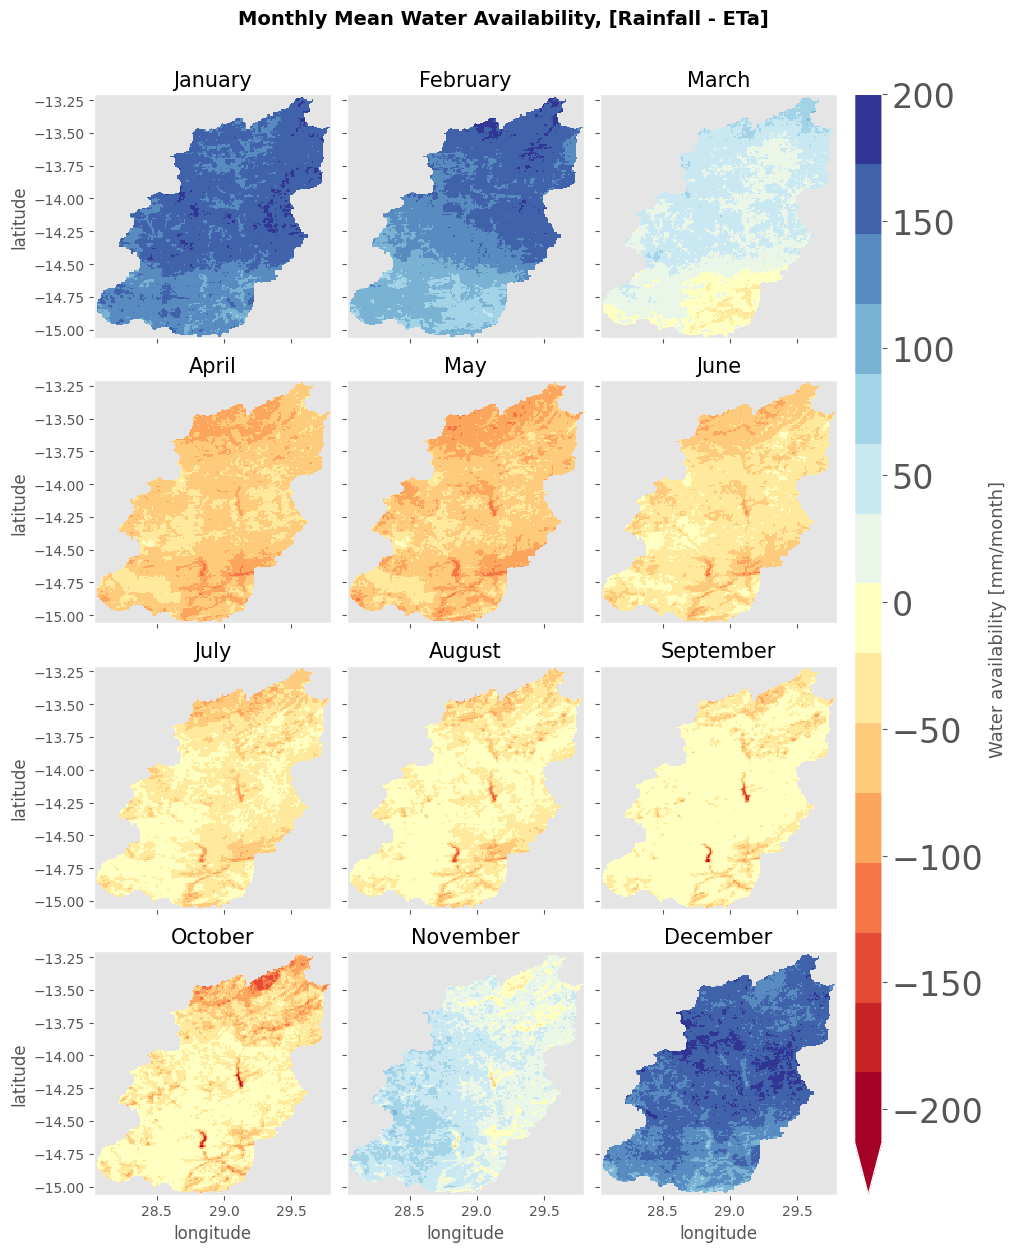

In [16]:
# Create colormap with discrete colors
cmap = plt.cm.RdYlBu
cmap = mcolors.ListedColormap(cmap(np.linspace(0, 1, 15)))  # divide into 15 colors

# Plotting with adjusted colorbar. Save the plot as a variable for further manipulation
P_ETa_plot = monthly_P_ETa_series.plot(size=3,aspect=1,col='month',col_wrap=3, sharex=True,cmap=cmap,vmin=-213, vmax=200, add_colorbar=True,
                                       cbar_kwargs=dict(location='right',shrink=1, aspect=40, pad=0.02))
plt.suptitle('Monthly Mean Water Availability, [Rainfall - ETa]', x=0.5, y=1.04, size=14, weight='bold')

# Customize font size for colorbar labels and ticks
cbar = P_ETa_plot.cbar  # Get the colorbar object
cbar.ax.tick_params(labelsize=24)  # Increase tick label font size
cbar.set_label('Water availability [mm/month]', size=13)  # Increase colorbar label font size

# Add individual subplot titles for each month
for i, ax in enumerate(P_ETa_plot.axes.flat):
    ax.set_title(calendar.month_name[i + 1], fontsize=15, weight='regular')

plt.savefig(f'{output_dir}/MonthlyMeanWaterAvailability.png')
plt.show()

**Plotting monthly water balance in 5 classes**  
We then classify and visualize the monthly water balance using five predefined classes in Table 4 1 based on water availability levels (e.g., Very Dry to Very Wet). The table of classification is shown below.  

**Classification and interpretation**

| **Description**  | **Water Availability ranges (mm)** |
|:--------------   |:---------------------:|
| *Very Wet*       | P-ET >= 101           |
| *Moderately Wet* | 51 =< P-ET =< 100     |
| *Normal*         | -50 =< P-ET =< 50    |
| *Moderately Dry* | -100 =< P-ET =< -51   |
| *Very Dry*       | P-ET <= -101           |  

Type and run the following code below to plot the results in the above classes with defined colours.

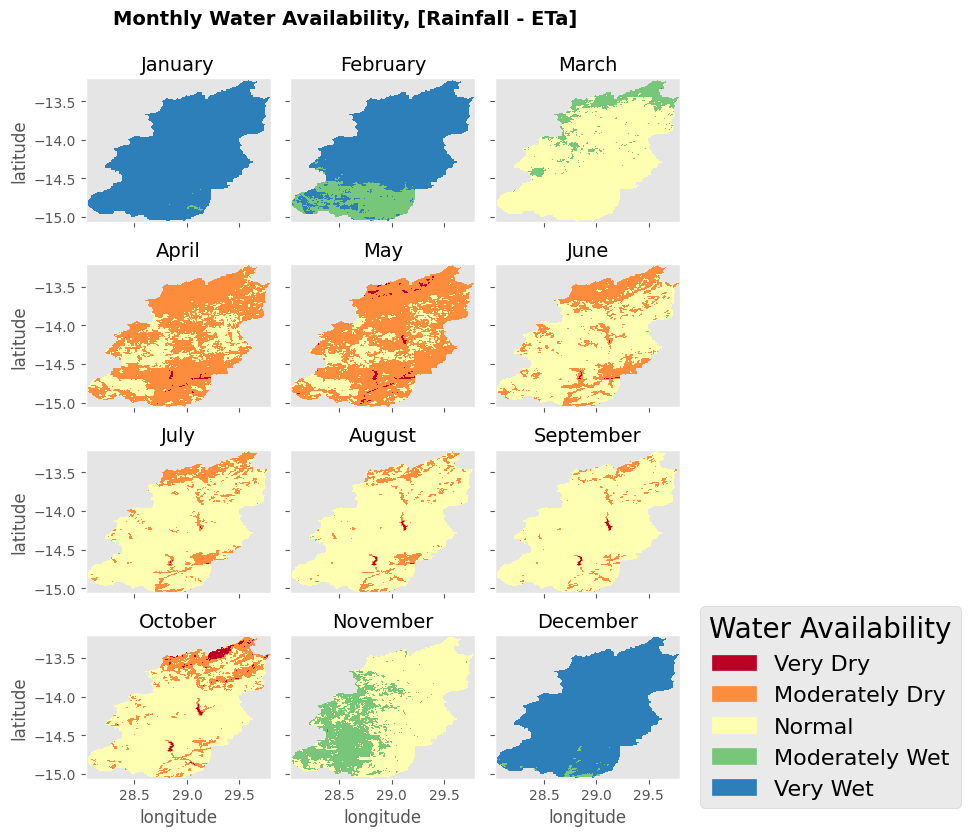

In [32]:
# Define the custom colormap
colors = ['#bd0026', '#fd8d3c', '#ffffb2', '#78c679', '#2c7fb8']
cmap = mcolors.ListedColormap(colors)
# Define the boundaries for the discrete classess
bounds = [-215, -101, -50, 50, 100, 200]
norm = mcolors.BoundaryNorm(bounds, cmap.N)
# Plotting
monthly_P_ETa_series.plot(size=2,aspect=1,col='month', col_wrap=3, sharex=True, cmap=cmap, norm=norm, add_colorbar=False)
plt.suptitle('Monthly Water Availability, [Rainfall - ETa]', x=0.5, y=1.04, size=14, weight='bold')
# Add individual subplot titles for each month
for i, ax in enumerate(plt.gcf().axes):  # Exclude colorbar axis
    ax.set_title(calendar.month_name[i + 1], fontsize=14, weight='regular')
# Create legend
legend_labels = ['Very Dry', 'Moderately Dry', 'Normal', 'Moderately Wet', 'Very Wet']
patches = [mpatches.Patch(color=colors[i], label=legend_labels[i]) for i in range(len(legend_labels))]
plt.legend(handles=patches,
           title='Water Availability',
           bbox_to_anchor=(1.05, 0.5),
           loc= 'center left',
           fontsize=16,
           title_fontsize=20)

plt.savefig(f'{output_dir}/MonthlyWaterAvailability.png')
plt.show()

### Grouping of rainfall and ETa into the annual time scale  
Water availability assessment is conducted on an annual scale to support the temporal analysis of the water balance.

In [18]:
# Annual totals and annual mean
# Rainfall 
# Similar approach and explanations to the monthly summaries
reproj_rainfall_mean_annual_series = reproj_rainfall_masked.groupby('time.year').sum('time').compute()
reproj_rainfall_mean_annual_series = reproj_rainfall_mean_annual_series.where(reproj_rainfall_mean_annual_series>=0)

# ETA
ETa_monthly_mean = ETa.groupby('time.month').mean('time').compute()
ETa_total_annual_series = ETa.groupby('time.year').sum('time').compute()

# Water availability at annual scales
# Calculation of water availability by subtracting ETa_total_annual_series from reproj_rainfall_mean_annual_series 
annual_P_ETa_series = reproj_rainfall_mean_annual_series - ETa_total_annual_series

**Plot Annual water availability**  
As we plot the monthly balance, it's also important to plot the annual balance to see the annual variation.  
We will have two plots:  
* Temporal annual water balance and  
* Spatio-temporal water balance in the form of animation  


**Temporal annual water balance**  

The following code will estimate the mean for the entire area and assign a single mean for the area for each year and plot it

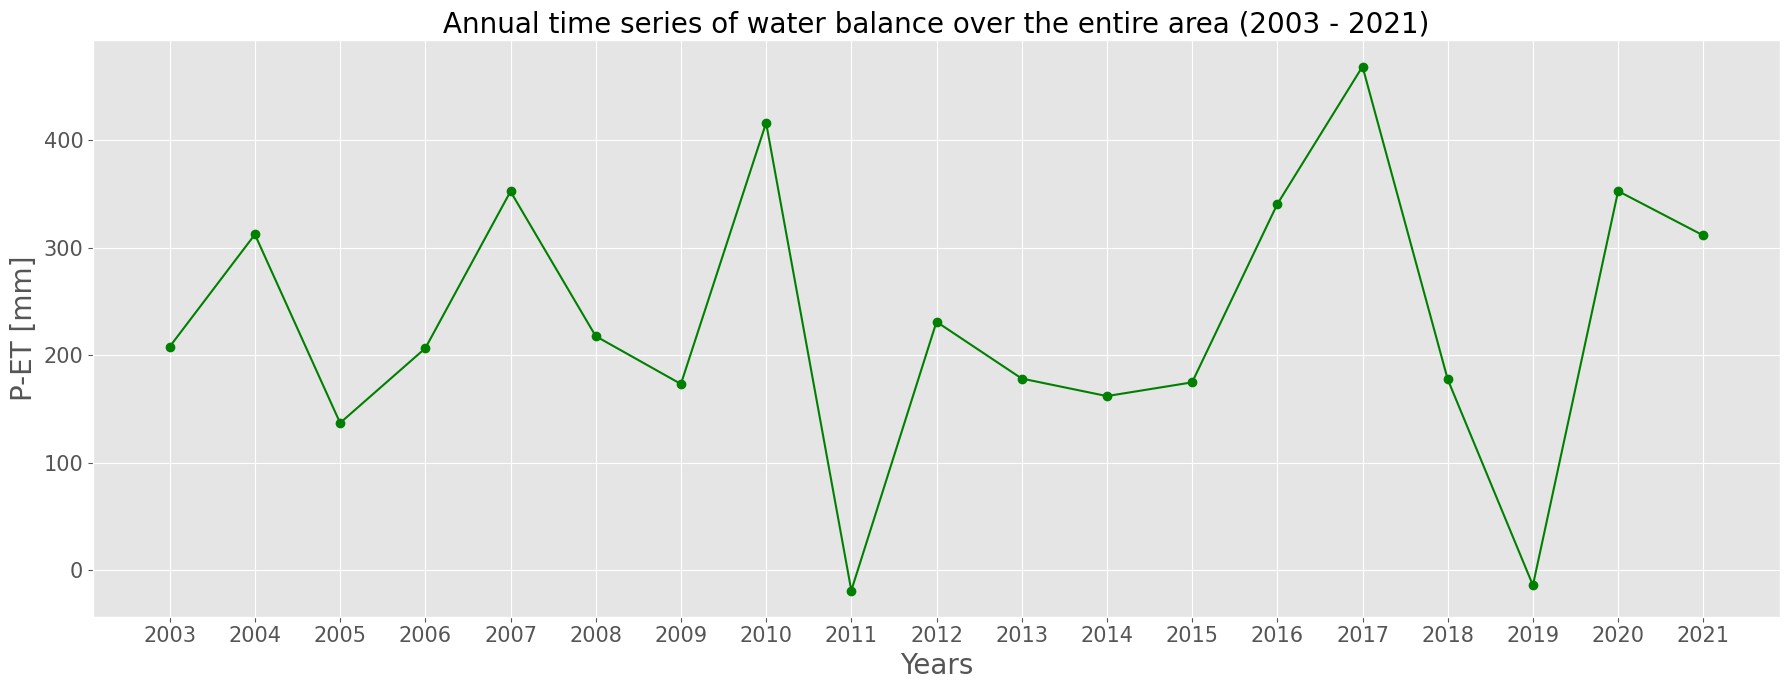

In [19]:
# estimate the mean for the entire area for each year
annual_P_ETa_series_mean = annual_P_ETa_series.mean(dim=["longitude", "latitude"])

# Plot
# Extract years from the data for x-axis
years = annual_P_ETa_series_mean.year

plt.figure(figsize=(18, 7))
plt.plot(years, annual_P_ETa_series_mean, marker="o", color="green")
plt.title("Annual time series of water balance over the entire area (2003 - 2021)", size = 20)
plt.xlabel("Years", size = 20)
plt.ylabel("P-ET [mm]", size = 20)
plt.xticks(years, fontsize=15)  # Font size for x-axis ticks
plt.yticks(fontsize=15)  # Font size for y-axis ticks
plt.tight_layout()
plt.savefig(f'{output_dir}/AnnuaTimeSeriesWaterBalance.png')
plt.show()

**Spatio-temporal annual  water balance - Animation**  
The first thing will be to convert the xarray dataframe of the annual P-ET to an xarray dataset and then plot the animation with the `xr_animation` function.

In [20]:
# The following are necesary to plot the the animation

# Rename 'year' variable in our data to 'time' and convert data array to dataset with variable name "P_ET"
annual_P_ETa_series_animation = annual_P_ETa_series.rename({"year": "time"}).to_dataset(name = 'P_ET')

# Format the years to a datetime format and clip out the area outside our interest
annual_P_ETa_series_animation.coords['time'] = pd.to_datetime(annual_P_ETa_series_animation.coords['time'], format='%Y')
annual_P_ETa_series_animation = annual_P_ETa_series_animation.rio.clip(lusen_bnd.geometry)

annual_P_ETa_series_animation.P_ET.min(), annual_P_ETa_series_animation.P_ET.max()

(<xarray.DataArray 'P_ET' ()> Size: 8B
 array(-1167.7043457)
 Coordinates:
     spatial_ref  int64 8B 0,
 <xarray.DataArray 'P_ET' ()> Size: 8B
 array(968.75109863)
 Coordinates:
     spatial_ref  int64 8B 0)

Now we plot our annual spatio-temporal series animation

Exporting animation to Results/Animation_P-ET_Annual.gif


  0%|          | 0/19 (0.0 seconds remaining at ? frames/s)

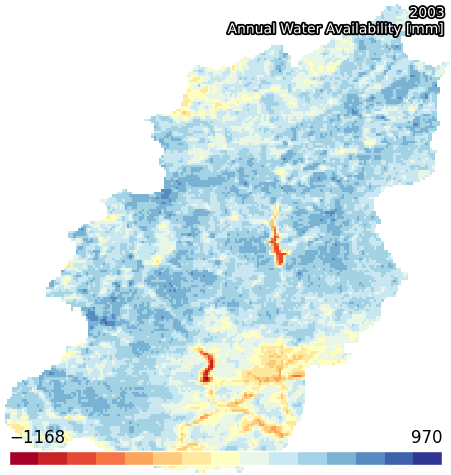

In [21]:
from IPython.display import Image
# Create colormap with discrete colors
cmap = plt.cm.RdYlBu
cmap = mcolors.ListedColormap(cmap(np.linspace(0, 1, 15)))
# Create spatio-temporal series animation of the water balance:
xr_animation(
    ds=annual_P_ETa_series_animation,
    bands=["P_ET"],
    output_path=f"{output_dir}/Animation_P-ET_Annual.gif",
    show_text="Annual Water Availability [mm]",
    interval=1000,
    width_pixels=325,
    imshow_kwargs={"cmap": cmap, "vmin": -1168, "vmax": 970},
    colorbar_kwargs={"colors": "black"},
    annotation_kwargs={"fontsize": 10},
    show_date='%Y'
)
# Plot the animation
plt.close()
Image(filename=f"{output_dir}/Animation_P-ET_Annual.gif")

**Estimate mean annual water balance**  
We would also like to gain an understanding of the annual average water balance in the area. To do this, we need to estimate the long-term mean annual water balance over the entire study period. Please see the code below for this step.

In [22]:
# Estimate annual P-ET
P_ETa_Annual = annual_P_ETa_series.mean(dim="year")

# Clip it to the study area again to get rid of all null (-9999) figures
P_ETa_Annual = P_ETa_Annual.rio.clip(lusen_bnd.geometry, drop = True)

# Check the max and min values
P_ETa_Annual.min(),P_ETa_Annual.max()

(<xarray.DataArray ()> Size: 8B
 array(-881.8538208)
 Coordinates:
     spatial_ref  int64 8B 0,
 <xarray.DataArray ()> Size: 8B
 array(698.69458008)
 Coordinates:
     spatial_ref  int64 8B 0)

**Plot the mean annual water balance**  
Here, we visualize the mean annual water balance across the study area using the map. A custom colormap is applied to highlight spatial differences in water availability.

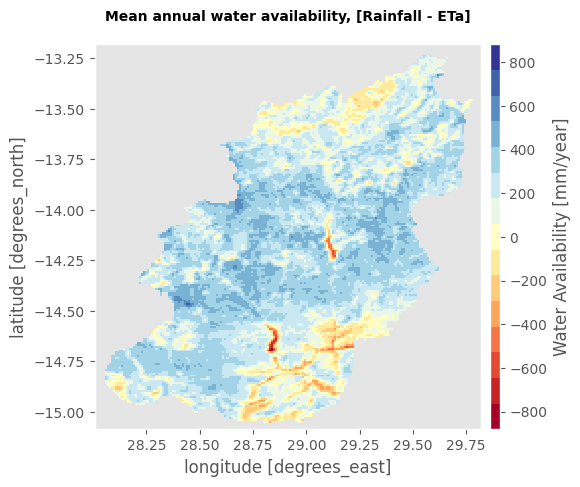

In [23]:
## plotting
# Create colormap with discrete colors
cmap = plt.cm.RdYlBu
cmap = mcolors.ListedColormap(cmap(np.linspace(0, 1, 15)))

fig, ax = plt.subplots(figsize=(6, 5))
P_ETa_Annual.plot(ax=ax,cmap=cmap,  add_colorbar=True,
                 cbar_kwargs=dict(label='Water Availability [mm/year]',location='right', shrink=1, aspect=40,  pad=0.02))
plt.title('Mean annual water availability, [Rainfall - ETa]', x=0.5, y=1.04, size=10, weight='bold')
# Adjust axis limits to show all corners of the study area
ax.set_xlim([lusen_bnd.total_bounds[0] - 0.03, lusen_bnd.total_bounds[2] + 0.02])
ax.set_ylim([lusen_bnd.total_bounds[1] - 0.02, lusen_bnd.total_bounds[3] + 0.02])
plt.savefig(f'{output_dir}/MeanAnnualWaterAvailability.png')
plt.show()

**Plotting the Mean Annual water availabilty into clasess**  
WE now plot the mean annual water availability into five distinct categories based on predefined value ranges. A custom color map and classification boundaries are used to represent varying levels of water availability—from Very Dry to Very Wet. The resulting map offers a clear and interpretable view of the spatial distribution of average annual water conditions across the study area

Given the range -882 to 699, we can divide it into 5 classes as follows:

* Very Wet: P-ET > 500

* Moderately Wet: For P-ET in the range 200, 500

* Normal: For P-ET in the range -200, 200

* Moderately Dry: For P-ET in the range -500, -200

* Very Dry: P-ET < -500


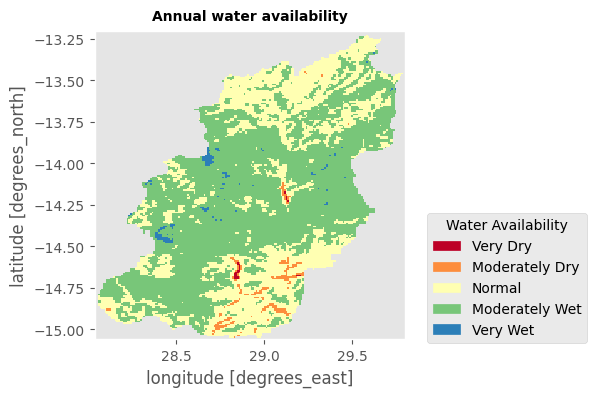

In [24]:
# Define the custom colormap
colors = ['#bd0026', '#fd8d3c', '#ffffb2', '#78c679', '#2c7fb8']
cmap = mcolors.ListedColormap(colors)

# Define the boundaries for the discrete values
bounds = [-882, -500, -200, 200, 500, 699]
norm = mcolors.BoundaryNorm(bounds, cmap.N)
# Plotting
P_ETa_Annual.plot(size=4, aspect=1, cmap=cmap, norm=norm, add_colorbar=False)  # Remove the colorbar
plt.title('Annual water availability', x=0.5, y=1.01, size=10, weight='bold')
## creating the legend
legend_labels = ['Very Dry', 'Moderately Dry', 'Normal', 'Moderately Wet', 'Very Wet']
patches = [mpatches.Patch(color=colors[i], label=legend_labels[i]) for i in range(len(legend_labels))]
plt.legend(handles=patches,
           title='Water Availability',
           bbox_to_anchor=(1.05, 0.2),
           loc= 'center left',
           fontsize=10,
           title_fontsize=10)
plt.savefig(f'{output_dir}/AnnualWaterAvailability.png')
plt.show()

## Water balance for each Sub-catchment  
There are multiple sub-catchments in the study area and we would like to estimate the water balnce for each sub-catchment. First thing will be to load into the script the subcatchments shapefile.
Then extract mean monthly and annual balance for each sub-catchment.

In [25]:
# subcatchments boundaries
sub_catch = gpd.read_file("Data/Lunsemfwa_subcatchments.json")
sub_catch.head()

,FID,OBJECTID,NAME,SUB_CATCH,Perimeter_,Area_sq_km,Area_Sq__1,geometry
0,0,130,Upper Mulungushi,Mulungushi (Middle Lunsemfwa),105.845385,480.608,48060.770,"POLYGON ((687860.163 8420904.534, 688121.478 8..."
1,1,131,Mubotwe,Mulungushi (Middle Lunsemfwa),114.389038,570.479,57047.922,"POLYGON ((707893.912 8432737.94, 707943.763 84..."
2,2,132,Munshibamba,Upper Lunsemfwa,157.036650,995.593,99559.329,"POLYGON ((769344.603 8476023.304, 769183.274 8..."
3,3,133,Lunsemfwa (Headwaters),Upper Lunsemfwa,311.372891,2768.512,276851.213,"POLYGON ((782838.842 8517025.033, 782758.833 8..."
4,4,135,Mkushi (Headwaters),Upper Lunsemfwa,162.667268,666.784,66678.418,"POLYGON ((803008.617 8511821.374, 802938.232 8..."


**Visualize sub-catchments**  
Here is to have a quick interactive visualization of the sub-catchment boundaries using the explore() function from GeoPandas.

In [26]:
# Visulize the loaded geodata
sub_catch.explore(color='tan',style_kwds=dict(fill=True,opacity=0.5,color='red'))

**Zonal statistics for each sub-catchment**  
For the zonal stats to work, our data needs to be in same coordinates with subcatchment.
So we need to assign same `CRS` to both before doing the zonal stats.  Note that since we have multiple subcatchments, we will use a `for loop` iteration to make the work easier and faster. Comments are added to each code to show what each code does.  


In [27]:
# Assign same crs to both
monthly_P_ETa_series = monthly_P_ETa_series.rio.write_crs("EPSG:4326", inplace=True)
sub_catch = sub_catch.to_crs(epsg=4326)
# Get transformation values from data for use in the zonal statistics
affine = monthly_P_ETa_series.rio.transform()
# Select ID and Name columns from sub_catch geodataframe and create new dataframe as "df" with only two columns
# this will be used to store the data for each subcatchment
df = sub_catch[['OBJECTID', 'NAME']]

In [28]:
# Iterate through month dimension and compute zonal statistics
for month in monthly_P_ETa_series.month.data:
# Select P-ET grid for the month
    da =  monthly_P_ETa_series.sel(month=month)
 # Get month abbreviated name using calendar function
    month_name = calendar.month_abbr[month]
 # Compute zonal statistics and get result as GeoJSON
    zonal_stat = zonal_stats(sub_catch, da.values, affine=affine, stats='mean',geojson_out=True)
 # Select ID and mean fields only
    zonal_stat = gpd.GeoDataFrame.from_features(zonal_stat)[['OBJECTID','mean']]
 # Rename mean to month name
    zonal_stat = zonal_stat.rename(columns={'mean':month_name})
 # Append result to df
    df = pd.merge(df,zonal_stat, on='OBJECTID').round(0)
# Compute mean annual value as a new column in the 'df' dataframe
df['Annual'] = df.loc[:,'Jan':'Dec'].sum(axis=1)
# export or save to your folder as a csv file for further analysis in a spreadsheet
df.to_csv(f"{output_dir}/lusenfwa_sub-catchments_waterbalance.csv")

# view the results
df

,OBJECTID,NAME,Jan,Feb,Mar,Apr,May,Jun,Jul,Aug,Sep,Oct,Nov,Dec,Annual
0,130,Upper Mulungushi,161.0,123.0,43.0,-42.0,-46.0,-21.0,-12.0,-11.0,-5.0,-14.0,61.0,154.0,391.0
1,131,Mubotwe,156.0,132.0,38.0,-51.0,-51.0,-31.0,-22.0,-17.0,-8.0,-18.0,45.0,156.0,329.0
2,132,Munshibamba,155.0,160.0,30.0,-57.0,-59.0,-40.0,-34.0,-29.0,-27.0,-52.0,16.0,154.0,217.0
3,133,Lunsemfwa (Headwaters),151.0,162.0,48.0,-69.0,-78.0,-56.0,-48.0,-37.0,-28.0,-64.0,16.0,152.0,149.0
4,135,Mkushi (Headwaters),162.0,155.0,49.0,-57.0,-64.0,-39.0,-33.0,-25.0,-24.0,-56.0,17.0,156.0,241.0
5,137,Lesser Mkushi,163.0,147.0,42.0,-57.0,-62.0,-35.0,-27.0,-19.0,-16.0,-42.0,22.0,157.0,273.0
6,142,Chowa/Muswishi,151.0,108.0,36.0,-48.0,-50.0,-24.0,-14.0,-8.0,-4.0,-9.0,72.0,154.0,364.0
7,158,Muchinda,126.0,86.0,-11.0,-70.0,-72.0,-46.0,-38.0,-32.0,-23.0,-31.0,33.0,112.0,34.0
8,159,Lower Mulungushi,123.0,82.0,-14.0,-71.0,-69.0,-42.0,-33.0,-31.0,-24.0,-35.0,31.0,122.0,39.0
9,162,Lower Mulungushi,134.0,96.0,5.0,-72.0,-72.0,-47.0,-35.0,-30.0,-19.0,-27.0,48.0,135.0,116.0


In [29]:
# Refine dataset for plotting
# Remove the NAME column from the extracted subcatchemnt results and merge it with the original geodatframe of the subcatchment
citi_mean = df.drop('NAME', axis=1)
sub_catch_1 = sub_catch.merge(citi_mean, on='OBJECTID')
sub_catch_1.head()

,FID,OBJECTID,NAME,SUB_CATCH,Perimeter_,Area_sq_km,Area_Sq__1,geometry,Jan,Feb,...,Apr,May,Jun,Jul,Aug,Sep,Oct,Nov,Dec,Annual
0,0,130,Upper Mulungushi,Mulungushi (Middle Lunsemfwa),105.845385,480.608,48060.770,"POLYGON ((28.74147 -14.27727, 28.7439 -14.2792...",161.0,123.0,...,-42.0,-46.0,-21.0,-12.0,-11.0,-5.0,-14.0,61.0,154.0,391.0
1,1,131,Mubotwe,Mulungushi (Middle Lunsemfwa),114.389038,570.479,57047.922,"POLYGON ((28.9262 -14.1689, 28.92667 -14.16959...",156.0,132.0,...,-51.0,-51.0,-31.0,-22.0,-17.0,-8.0,-18.0,45.0,156.0,329.0
2,2,132,Munshibamba,Upper Lunsemfwa,157.036650,995.593,99559.329,"POLYGON ((29.49101 -13.77264, 29.48954 -13.773...",155.0,160.0,...,-57.0,-59.0,-40.0,-34.0,-29.0,-27.0,-52.0,16.0,154.0,217.0
3,3,133,Lunsemfwa (Headwaters),Upper Lunsemfwa,311.372891,2768.512,276851.213,"POLYGON ((29.61166 -13.40099, 29.61093 -13.401...",151.0,162.0,...,-69.0,-78.0,-56.0,-48.0,-37.0,-28.0,-64.0,16.0,152.0,149.0
4,4,135,Mkushi (Headwaters),Upper Lunsemfwa,162.667268,666.784,66678.418,"POLYGON ((29.7983 -13.44599, 29.7977 -13.45056...",162.0,155.0,...,-57.0,-64.0,-39.0,-33.0,-25.0,-24.0,-56.0,17.0,156.0,241.0


**Plotting water balance for sub-catchments**  
This step visualizes the mean annual water balance across Lusenfwa sub-catchments by plotting the computed values using custom classification bins. The sub-catchments are color-coded based on defined thresholds, making it easy to distinguish areas with low, moderate, and high-water availability. Now let's plot our results spatially.

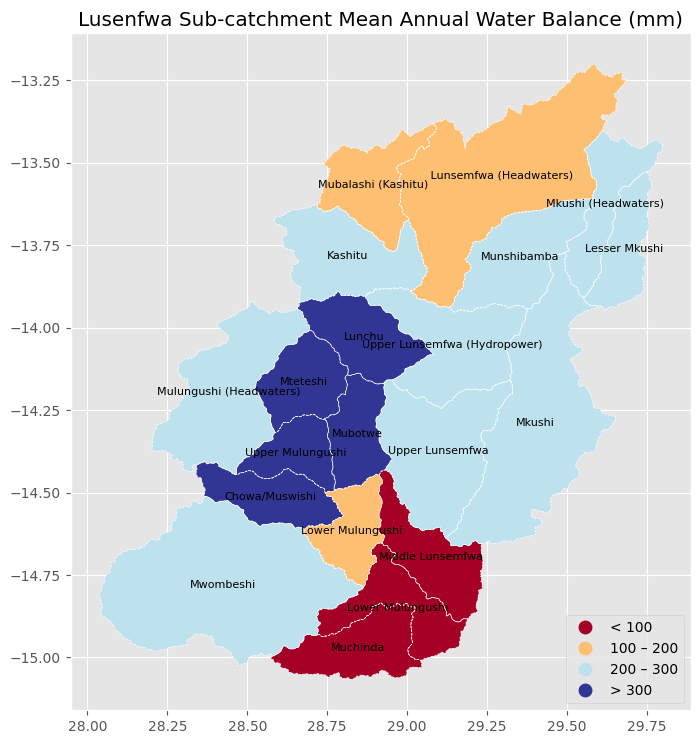

In [30]:
# Set list of bins for classification
bins = [100, 200, 300, 400]
# Define legend labels for each class
class_label = [
    '< 100',
    '100 – 200',
    '200 – 300',
    '> 300']
# Create figure and axis
fig, axes = plt.subplots(figsize=(8, 10))

# Plot the annual rainfall data using user-defined classification bins
sub_catch_1.plot(column='Annual', cmap='RdYlBu', scheme='user_defined', classification_kwds={'bins': bins}, ax=axes,
                 legend=True,legend_kwds={'fmt': '{:,.0f}',
                                          'loc': 'lower right',
                                          'labels': class_label}
                )
# Add sub-catchment boundary to the plot
sub_catch.boundary.plot(color='white', ax=axes, linewidth=0.5, linestyle='--')
# Label polygons with their 'name' attribute
for idx, row in sub_catch_1.iterrows():
    centroid = row['geometry'].centroid
    axes.text(
        centroid.x,
        centroid.y,
        row['NAME'],
        fontsize=8,
        color='black',
        ha='center',
        va='center'
    )
plt.title('Lusenfwa Sub-catchment Mean Annual Water Balance (mm)')
plt.savefig(f'{output_dir}/MeanAnnualWaterBalance.png')
plt.show()

**Plot interactive map**  
And finally, we create an interactive map of the mean annual water balance across sub-catchments using GeoPandas’ explore() function.

In [31]:
# Plot interactive map using inbuilt GeoPandas explore() method
sub_catch_1.explore('Annual', cmap='RdYlBu', popup = True, k=6, scheme='FisherJenks',tiles='OpenStreetMap',
                    style_kwds ={ 'stroke': True,
                               'color': 'white',
                               'width': 1,
                               'fillOpacity': 0.7 },
                  legend_kwds={ 'caption': 'P-ETa (mm)',
                               'colorbar': False}
                              )

# Comments on Water Availability

Monthly water availability across the sub-catchments shows clear spatial and temporal variability. Dry periods are consistently observed from April to October, during which evapotranspiration (ETa) exceeds rainfall. This negative water balance indicates a moisture deficit, which can potentially result in crop stress and reduced water availability for other uses. During these months, large portions of the catchment shift into Moderately Dry and Very Dry classes. In contrast, January to March and December exhibit positive water balances, with rainfall exceeding ETa, leading to Very Wet and Moderately Wet conditions. Spatially, sub-catchments exhibit distinct patterns, with certain areas remaining wetter or drier throughout the year. On an annual scale, however, most sub-catchments fall within the Moderately Wet to Normal water availability categories, suggesting generally favorable hydrological conditions. These findings can inform irrigation scheduling, infrastructure planning, and targeted water allocation decisions, ensuring water is used efficiently across.